In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [ ]:
cv2.imread("/Users/conueyn/Documents/Science Research/Total Images/0001.jpg").shape

In [ ]:
DATADIR = "/Users/conueyn/Documents/Science Research/Total Images"

path = DATADIR

for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break

In [5]:
print(img_array.shape)

(512, 512, 3)


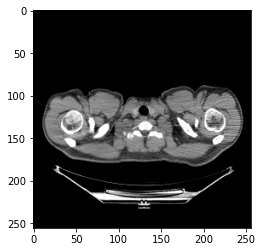

In [6]:
IMG_SIZE = 256

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap="gray")
plt.show()

In [7]:
img_rows = 28
img_cols = 3
channels = 1
img_shape = (img_rows, img_cols, channels)

In [8]:
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)

In [9]:
def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [10]:
def train(epochs, batch_size=128, save_interval=50):

    DATADIR = "/Users/conueyn/Documents/Science Research/CT Scans"
    CATEGORIES = ["Recognition Training", "Prediction Training"]
    
    # Load the dataset
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        for img in os.listdir(path):
            X_train = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    
    IMG_SIZE = 28
    
    X_train = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
  
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [11]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/Users/conueyn/Documents/Science Research/Generated CTs/Generated_%d.jpg" % epoch)
    plt.close()

In [12]:
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 84)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               43520     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 175,105
Trainable params: 175,105
Non-trainable params: 0
__________________________________________________

In [13]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 1024)             

In [14]:
discriminator.trainable = False  

valid = discriminator(img)  #Validity check on the generated image

In [ ]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=1500, batch_size=32, save_interval=10)